#Automatic differentiation (Micrograd)

- One of the **great innovations** that frameworks bring to the world of **deep learning is the way we calculate partial derivatives automatically**, also called automatic **differentiation**.

In [ ]:
import tensorflow  as tf
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x+5

In [ ]:
f(3.0)

20.0

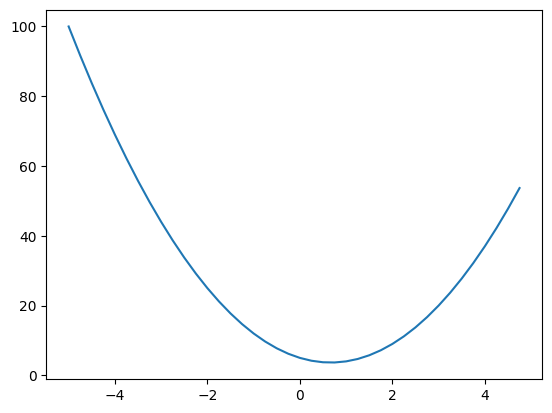

In [ ]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)

- Increasing the size of the **H-step**

In [ ]:
h=0.00001
x=2/3
(f(x+h)-f(x))/h

3.0000002482211127e-05

In [ ]:
# exemple more complex
a=2.0
b=-3.0
c=10
d=a*b+c
print(d)

4.0


- Calculating the partial drifts of the function d with **respect to ,b,c** as we increase **the step h** **in the positive direction**

In [ ]:
h=0.001 #steps
a=2.0
b=-3.0
c=10.0

d1=a*b+c
a+=h
d2=a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 3.997
slope -3.0000000000001137


- **In neural networks**, there will always be a **large number of variables** that we need to calculate the derivatives, so we need to create a d**ata structure that deals well with this issue**

In [ ]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other=other  if isinstance(other,Value) else Value(other) #If other is not a class of the Valuer class
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
      return self*-1

    def __sub__(self,other):
      return  self + (-other)

    def __mul__(self, other):
        other=other  if isinstance(other,Value) else Value(other) ##If other is not a class of the Valuer class
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
      assert isinstance(other, (int,float)),"only supporting int/float power for now"
      out=Value(self.data**other , (self,),f'**{other}')

      def  _backward():
        self.grad=other * self.data**(other-1)*out.grad
      out._backward=_backward
      return out

    def __truediv__(self,other):
      return self*other**-1

    def __rmul__(self, other):
        other=other  if isinstance(other,Value) else Value(other) ##If other is not a class of the Valuer class
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def backward(self):

        self.grad = 1.0 #base case
        topo = []
        visited = set()

        def build_topo(v): #Topological sort (DAGs)
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        for node in reversed(topo):
            node._backward()

    def tanh(self):
        x = self.data
        x=np.round(x,3)
        t = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out


    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad+=out.data * out.grad
        out._backward = _backward
        return out

- Now, we need to see in a more **visual way**, how this is **happening**.

In [ ]:
a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10.0,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(-2.0,label='f')
L=d*f
L

Value(data=-8.0)

In [ ]:
from graphviz import Digraph

In [ ]:
def trace(root):
    nodes, edges = set(), set()
    #builds  a set all nodes and edges in a graph
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        # for any value in the graph, create a rectangular {'record'} node for it

        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation,create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            #and connect this node to it
            dot.edge(uid + n._op,uid)



    for n1, n2 in edges:
      # connect n1 ti the op node of 2
          dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

- What can we do **now ?** , well , once we can map the operations that involve the **forward pas**s, we now need to think about how we can do the **backward pass**, ...

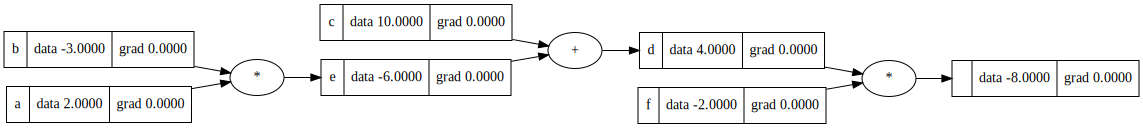

In [ ]:
draw_dot(L)

In [ ]:
# Basically that's what we need to do
'''
dL/dL
dL/dD
dL/dF
dL/dC
dL/dE
dL/dB
dL/dA

'''

'\ndL/dL\ndL/dD\ndL/dF\ndL/dC\ndL/dE\ndL/dB\ndL/dA\n\n'

- We're calculating the partial ***derivative of the output L*** , **relative to each variable that we have.**

In [ ]:
a.data+=0.01*a.grad  #0.01 is the step we are taking.
b.data+=0.01*b.grad  #Moving forward in the direction of the gradient.
c.data+=0.01*c.grad
f.data+=0.01*f.grad

e=a*b
d=e+c
L=d*f
print(L.data)
#Here we expect the error to increase since we're following the direction of the gradient.

-8.0


In [ ]:
def lol():
  '''
  Here, we are manually calculating the partial.
  derivations of the output function in relation to each parameter.
  literally needing to display the gradients of each variable.
  '''
  h=0.001
  a=Value(2.0,label='a')
  b=Value(-3.0,label='b')
  c=Value(10.0,label='c')
  e=a*b;e.label='e'
  d=e+c;d.label='d'
  f=Value(-2.0,label='f')
  L=d*f
  L1=L.data

  h=0.001
  a=Value(2.0,label='a')
  b=Value(-3.0,label='b')
  c=Value(10.0,label='c')
  e=a*b;e.label='e'
  d=e+c;d.label='d'
  f=Value(-2.0,label='f')
  f.data+=h
  L=d*f
  L2=L.data
  print((L2-L1)/h)

In [ ]:
lol()

3.9999999999995595


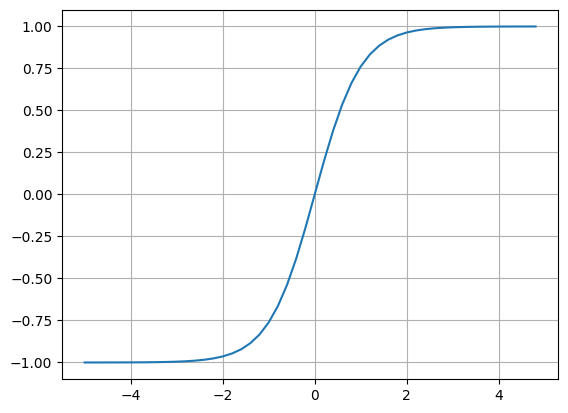

In [ ]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)));plt.grid();

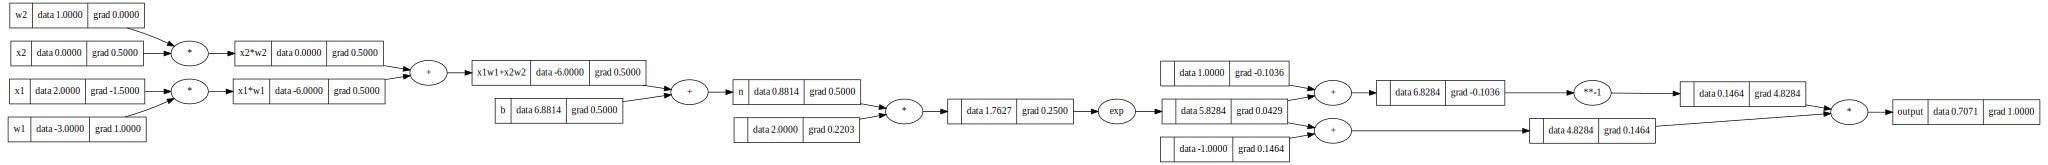

In [ ]:
#inputs x1,x2

x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')

#weights w1,w2

w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

# bias of the neuron
b=Value(6.8813735870195432,label='b')
x1w1=x1*w1;x1w1.label='x1*w1'
x2w2=x2*w2;x2w2.label='x2*w2'
x1w1xx2w2=x1w1+x2w2;x1w1xx2w2.label="x1w1+x2w2"
n=x1w1xx2w2+b;n.label='n'

# -------
e=(2*n).exp()
o=(e-1)/(e+1);o.label="output"
o.backward()
draw_dot(o)

- Now we need to calculate the ***backward pass***, calculate the partial derivatives of the output with respect to the **network parameters**.

In [ ]:
#dO/dO=1
o.grad=1.0
#dO/dN=1-o**2
n.grad=1-o.data**2
#dO/dX1W1xX2W2=dO/dO*dO/dN*dN/dX1W1xX2W2=0.5
b.grad=0.5
#dO/dX1W1xX2W2=dO/dO*dO/dN*dN/b=0.5
x1w1xx2w2.grad=0.5
#dO/dX1W1=dO/dO*dO/dN*dN/dX1W1xX2W2*dX1W1xX2W2/dX1W1=0.5
x1w1.grad=0.5
#dO/dX1W1=dO/dO*dO/dN*dN/dX1W1xX2W2*dX1W1xX2W2/dX1W2=0.5
x2w2.grad=0.5
#dO/dX1=dO/dO*dO/dN*dN/dX1W1xX2W2*dX1W1xX2W2/dX1W1*dX1W1/dX1=-(3)*(0.5)
x1.grad=x1w1.grad*w1.data
#dO/dW1=dO/dO*dO/dN*dN/dX1W1xX2W2*dX1W1xX2W2/dX1W1*dX1W2/dW1=(2)*(0.5)
w1.grad=x1w1.grad*x1.data
#dO/dX2=dO/dO*dO/dN*dN/dX1W1xX2W2*dX1W1xX2W2/dX2W2*dX2W2/X2=(1)*(0.5)
x2.grad=x2w2.grad*w2.data
#dO/dW2=dO/dO*dO/dN*dN/dX1W1xX2W2*dX1W1xX2W2/dX2W2*dX2W2/W2=(0)*(0.5)
w2.grad=x2w2.grad*x2.data

- **Through the chain rule**, we can perform **backward passing**, but we can see that **backward propagation** starts to **get a bit difficult** when there are a lot of **parameters in the network**.

- Since we have already been able to perform the **backpropagation through the computational graph**. Let's look at how we can do the same thing **using the PyTorch library**

In [ ]:
import torch

In [ ]:
x1=torch.Tensor([2.0]).double()                              ;x1.requires_grad=True
x2=torch.Tensor([0.0]).double()                              ;x2.requires_grad=True
w1=torch.Tensor([-3.0]).double()                             ;w1.requires_grad=True
w2=torch.Tensor([1.0]).double()                              ;w2.requires_grad=True
b=torch.Tensor([6.8813735870195432]).double()                ;b.requires_grad=True

n=x1*w1+x2*w2 + b
o=torch.tanh(n)
print(o.data.item())
o.backward()

print('---------')
print(x1.grad.item())
print(w1.grad.item())
print(x2.grad.item())
print(w2.grad.item())

0.7071066904050358
---------
-1.5000003851533106
1.0000002567688737
0.5000001283844369
0.0


In [ ]:
class Neuron:
  def __init__(self,nin):
    self.w=[Value(np.random.uniform(-1,1)) for _ in range(nin)]
    self.b=Value(np.random.uniform(-1,1))

  def __call__(self,x):
    z= sum((xi*wi for wi,xi in zip(self.w,x)),self.b)
    outs=z.tanh()
    return outs

  def  parameters(self):
    return self.w + [self.b]


class Layer:
  def __init__(self,nin,nout):
    self.neurons=[Neuron(nin) for _ in range(nout)]

  def  __call__(self,x):
    outs=[n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP :
  def __init__(self,nin, nouts): #MLP(3,[4,4,1]) [3,4,4,1]
    sz=[nin]+nouts
    self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x=layer(x)
    return x

  def parameters(self):
    return [p  for layer in self.layers for p in layer.parameters()]


In [ ]:
x=[1.0,2.0,3.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=0.4218990052500079)

In [ ]:
len(n.layers[0].parameters())

16

In [ ]:
#A simple dataset
xs=[[
    2.0,3.0,-1.0
],[
    3.0,-1.0,0.5
],[
    0.5,1.0,1.0
],[
    1.0,1.0,-1.0
]]

ys=[1.0,-1.0,-1.0,1.0] #the values of the response variables

In [ ]:
y_pred=[n(x) for x in xs]

In [ ]:
y_pred

[Value(data=0.700865700179157),
 Value(data=0.023995393061435742),
 Value(data=0.4967634432141285),
 Value(data=0.7661753101588356)]

In [ ]:
loss=[(ypred-ytrue)**2 for ypred,ytrue in zip(y_pred,ys)] #loss function
loss_fn=Value(0.0)

for idx_loss in loss:
  loss_fn+=idx_loss

loss_fn=loss_fn
loss_fn

Value(data=3.433022684861881)

In [ ]:
loss_fn.backward()

- Accessing the gradients of the first **layer of the network**

In [ ]:
n.layers[0].neurons[0].w[0].grad

1.5197292828074838

In [ ]:
n.layers[0].neurons[0].w[0].data

0.013990563181197624

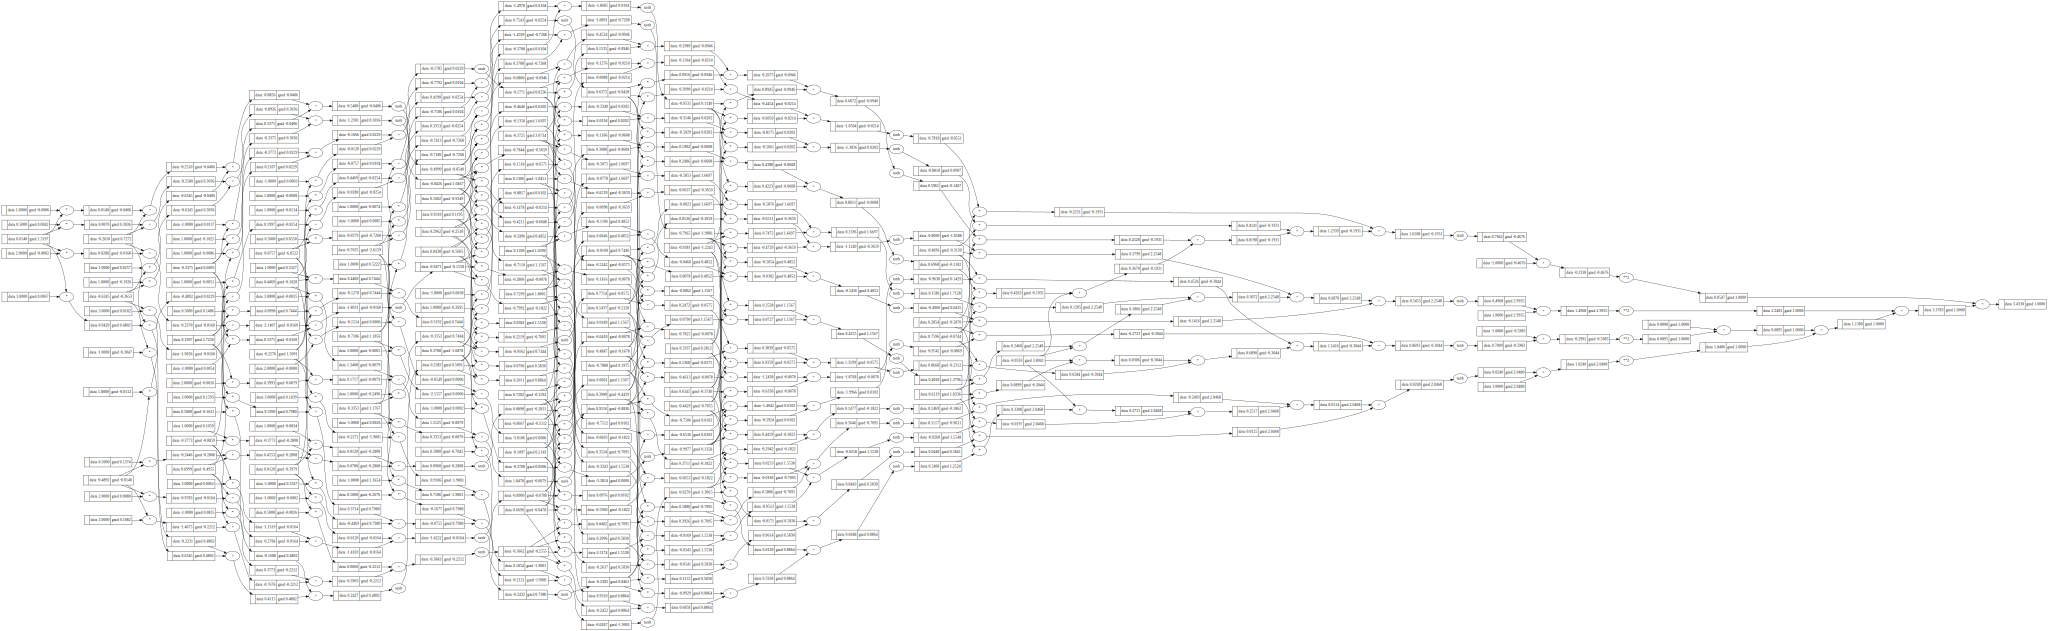

In [ ]:
draw_dot(loss_fn)

- Viewing the computational graphs after obtaining the gradients

- Once we have the cost function error, we can calculate how much the cost function changes by calculating the partial derivatives of the cost function with respect to the network parameters

#**Doing gradient descedent optimization manually, training the network**

In [ ]:
alpha=0.001

for p  in n.parameters():
  p.data+=-alpha*p.grad

In [ ]:
y_pred=[n(x) for x in xs]


In [ ]:
loss=[(ypred-ytrue)**2 for ypred,ytrue in zip(y_pred,ys)] #loss function
loss_fn=Value(0.0)

for idx_loss in loss:
  loss_fn+=idx_loss

loss_fn=loss_fn
loss_fn

Value(data=3.333063181156413)

- We can see now that the error we had before was a **little bigger than the one we have now**

- What happens **if we increase a little** bit of the step in the **right direction where the error is smaller?**

In [ ]:
alpha=0.1

for p  in n.parameters():
  p.data+=-alpha*p.grad

In [ ]:
y_pred=[n(x) for x in xs]


In [ ]:
loss=[(ypred-ytrue)**2 for ypred,ytrue in zip(y_pred,ys)] #loss function
loss_fn=Value(0.0)

for idx_loss in loss:
  loss_fn+=idx_loss

loss_fn=loss_fn
loss_fn

Value(data=2.3219241109785846)

- We can see that the **error is smaller**, this happens because of the iterations and the steps that we've taken in the **right direction,** that is, as we iterate, we're iteratively **updating the parameters of the network** by taking a bigger step in the **right direction**, or in the opposite direction of the **gradients**

#**Creating a mini  Training Loop**

In [ ]:
loss_fn=Value(0.0)
for steps in range(4):
  #foward pass
  y_pred=[n(x) for x in xs]
  loss=[(ypred-ytrue)**2 for ypred,ytrue in zip(y_pred,ys)]
  for idx_values in loss:
    loss_fn+=idx_values

  for p in n.parameters():
    p.grad=0.0

  #backward pass
  loss_fn.backward()

  #update
  for p in n.parameters():
    p.data+=-0.05*p.grad

  print(steps,loss_fn.data)

0 2.3219241109785846
1 2.935671393100506
2 10.812947828334753
3 18.812947828334753


- What have we **learned from all this?**, we can see that the frameworks that exist today are **very important when we have models that have billions or thousands of parameters**.. Calculating manually is **very complicated**, no one will want to do that.. Instead, we create a **framework that deals directly with this problem.**